In [141]:
# load libraries 
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt 
import numpy as np 
from data_files.NumpyImageDataset import NumpyImageDataset
from data_files.generate_submission import writeSubmissionFile
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler


In [142]:
# device configuration 
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# > dataset has PILImage images of range [0, 1]
# we transform them to tensors of normalized range [-1, 1]
# autoaugment_policy = transforms.AutoAugment()

# Update the transform for training data to include AutoAugment
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2,
                                       hue=0.2),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])



random_seed = 42
# torch.manual_seed(random_seed);
# hyper parameters 
num_epochs = 160
batch_size = 200
learning_rate = 0.001

In [143]:
# load the data train-validation data 
train_data = np.load('./data_files/cifar_train_data.npy').transpose((0,2,3,1))
train_label = np.load('./data_files/cifar_train_label.npy')
trainset = NumpyImageDataset(train_data, train_label, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # num workers?

# split into 80% training 20% validation 
dataset_size = len(train_loader.dataset)
split_idx = int(0.8 * dataset_size)

indices = np.random.permutation(dataset_size)
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_loader.dataset, batch_size = batch_size, sampler = train_sampler)
val_loader = DataLoader(train_loader.dataset, batch_size = batch_size, sampler = val_sampler)



In [144]:
# load the test data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
test_data = np.load('./data_files/cifar_test_data.npy').transpose((0,2,3,1))
test_label = np.load('./data_files/cifar_train_label.npy')[:10000] # change
testset = NumpyImageDataset(test_data, test_label, transform=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False) # num workers?


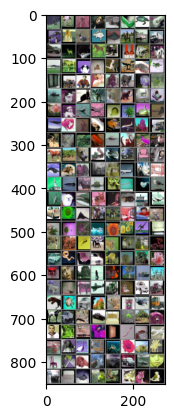

In [145]:
classes = [i for i in range(20)]

# test some images 
def imshow(img):
    img = img / 2 + 0.5 # unnormalize 
    npimg = img.numpy()
    # transpose from pytorch (channels, height, width) axes to matplotlib axes (height, width, channels)
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    
# sample some random training images 
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images 
imshow(torchvision.utils.make_grid(images))

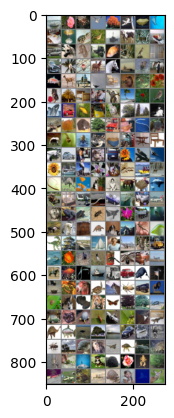

In [146]:
test_iter = iter(test_loader)
images = next(test_iter)
imshow(torchvision.utils.make_grid(images[0]))

In [ ]:
images.labels

In [149]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=20):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        dropout = nn.Dropout(p=0.2)
        out = dropout(out)
        out = self.fc(out)
        return out


def ResNet10():
    return ResNet(ResidualBlock)


In [150]:
model = ResNet10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.5, patience = 5)

In [ ]:
# Lists to store training and validation loss
train_losses = []
val_losses = []

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
n_total_steps = len(train_loader)
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{n_total_steps}], Training Loss: {loss.item():.4f}')


    # Calculate training accuracy and loss
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            val_loss = criterion(outputs, labels)

            total_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    scheduler.step()
#     scheduler.step(val_accuracy)

    # Calculate validation accuracy and loss
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%, Learning rate {optimizer.param_groups[0]['lr']}")

    # Plotting training and validation loss
    if(epoch+1)%10==0:
        print('graphs for epoch', epoch+1)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [153]:
# training only two blocks^
# testing loop 
with torch.no_grad():
    my_labels = np.array([])
    for images,_ in test_loader:
        images = images.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()
        my_labels = np.append(my_labels, predicted)

writeSubmissionFile(my_labels, 'my_labels20.csv')